# S4 WESAD XGBoost  

    Male Participant
    Age: 25
    Height (cm): 175
    Weight (kg): 90

# Load Tools

In [2]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier

In [4]:
sns.set(style="darkgrid")

In [5]:
import autoreload
%load_ext watermark
%load_ext autoreload
%autoreload 2
%watermark -a 'WForsythe' -d -t -v -p   numpy,pandas,cv2,xgboost,sklearn,seaborn,matplotlib,yellowbrick

WForsythe 2020-08-06 06:21:49 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 1.0.3
cv2 4.2.0
xgboost 1.0.2
sklearn 0.22.1
seaborn 0.9.0
matplotlib 3.2.2
yellowbrick 1.1


# Load and Process File

## Load File

In [8]:
%%time
data = 'D:/WESAD/'
s4_file = pd.read_pickle(data + 'S4/S4.pkl')
s4_file

Wall time: 12.2 s


{'signal': {'chest': {'ACC': array([[ 1.55539989, -0.07840002,  1.36240005],
          [ 1.51300001, -0.10699999,  1.45860004],
          [ 1.4460001 , -0.10420001,  1.06040001],
          ...,
          [ 0.89020002, -0.079     , -0.23000002],
          [ 0.8908    , -0.07980001, -0.22659999],
          [ 0.88940001, -0.0794    , -0.22780001]]),
   'ECG': array([[-1.40538025],
          [-1.3996582 ],
          [-1.39338684],
          ...,
          [ 0.11128235],
          [ 0.12547302],
          [ 0.13499451]]),
   'EMG': array([[ 0.04417419],
          [ 0.01547241],
          [-0.03204346],
          ...,
          [ 0.00567627],
          [ 0.01625061],
          [-0.00013733]]),
   'EDA': array([[1.09634399],
          [1.09443665],
          [1.09405518],
          ...,
          [2.48260498],
          [2.49443054],
          [2.49404907]]),
   'Temp': array([[32.506256],
          [32.49878 ],
          [32.50177 ],
          ...,
          [33.630707],
          [33.633728

## Process

### Separate chest features  from wrist  features 

In [9]:
cax = s4_file['signal']['chest']['ACC'][0:,0]
cay = s4_file['signal']['chest']['ACC'][0:,1]
caz = s4_file['signal']['chest']['ACC'][0:,2]
cecg = s4_file['signal']['chest']['ECG'][:,0]
cemg = s4_file['signal']['chest']['EMG'][:,0]
ceda = s4_file['signal']['chest']['EDA'][:,0]
ctemp = s4_file['signal']['chest']['Temp'][:,0]
cresp = s4_file['signal']['chest']['Resp'][:,0]
label = s4_file['label']

In [10]:
label

array([0, 0, 0, ..., 0, 0, 0])

### Change dictionary object to a numpy array and array to a dataframe

In [11]:
# Python | Numpy ndarray.T
# https://www.geeksforgeeks.org/python-numpy-ndarray-t/
# Numpy Array Cookbook: Generating and Manipulating Arrays in Python
# https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09

In [12]:
chest = [cax, cay, caz, cecg, cemg, 
         ceda, ctemp, cresp, label] 
ch_array = np.array(chest) 
ch_array = ch_array.T # transpose 
Columns = ['cax', 'cay', 'caz','cecg', 'cemg', 
          'ceda','ctemp', 'cresp', 'label' ]
ch_df = pd.DataFrame(ch_array, columns = Columns) 
ch_df

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,1.5554,-0.0784,1.3624,-1.405380,0.044174,1.096344,32.506256,2.836609,0.0
1,1.5130,-0.1070,1.4586,-1.399658,0.015472,1.094437,32.498779,2.839661,0.0
2,1.4460,-0.1042,1.0604,-1.393387,-0.032043,1.094055,32.501770,2.838135,0.0
3,1.3382,-0.0622,0.4234,-1.387436,-0.003799,1.094818,32.491302,2.839661,0.0
4,1.1958,-0.0306,-0.0164,-1.381165,0.020370,1.092911,32.501770,2.882385,0.0
...,...,...,...,...,...,...,...,...,...
4496095,0.8926,-0.0810,-0.2290,0.082443,0.008743,2.483749,33.650391,2.578735,0.0
4496096,0.8944,-0.0824,-0.2276,0.093796,-0.024673,2.480698,33.650391,1.963806,0.0
4496097,0.8902,-0.0790,-0.2300,0.111282,0.005676,2.482605,33.630707,2.581787,0.0
4496098,0.8908,-0.0798,-0.2266,0.125473,0.016251,2.494431,33.633728,2.571106,0.0


#### Check Statistics

In [13]:
ch_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,4496100.0,0.789582,0.118992,-0.009800,0.719800,0.806200,0.895800,1.694200
cay,4496100.0,-0.236378,0.151279,-0.622200,-0.394000,-0.194200,-0.115600,0.469000
caz,4496100.0,-0.350279,0.240648,-1.440200,-0.496200,-0.380000,-0.170400,1.947000
cecg,4496100.0,0.001240,0.234884,-1.499405,-0.073975,-0.024673,0.008560,1.499954
cemg,4496100.0,-0.002288,0.014199,-0.195877,-0.009430,-0.001968,0.004623,0.365891
ceda,4496100.0,2.176569,1.044990,0.912094,1.363754,1.538467,2.666855,5.508423
ctemp,4496100.0,33.298668,0.403770,32.342224,32.956757,33.245544,33.704956,34.092499
cresp,4496100.0,0.056295,2.481089,-20.941162,-1.226807,-0.074768,1.377869,21.275330
label,4496100.0,1.190566,1.589549,0.000000,0.000000,0.000000,2.000000,7.000000


#### Check Type

In [14]:
print(ch_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4496100 entries, 0 to 4496099
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   cax     float64
 1   cay     float64
 2   caz     float64
 3   cecg    float64
 4   cemg    float64
 5   ceda    float64
 6   ctemp   float64
 7   cresp   float64
 8   label   float64
dtypes: float64(9)
memory usage: 308.7 MB
None


### Concatenate classes 0, 1, 2, 3, and 4
    Classes 5, 6 and 7 correspond to timed periods in which the participant answered questionnaires, 
    therefore, only classes 0, 1, 2, 3, and 4 will be used 
    Additionally, the significant imbalance has been eliminated

In [15]:
loc0 = ch_df.loc[ch_df['label'] == 0]
loc1 = ch_df.loc[ch_df['label'] == 1]
loc2 = ch_df.loc[ch_df['label'] == 2]
loc3 = ch_df.loc[ch_df['label'] == 3]
loc4 = ch_df.loc[ch_df['label'] == 4]

In [16]:
ch_loc = pd.concat([loc0, loc1, loc2, loc3, loc4])
ch_loc

,cax,cay,caz,cecg,cemg,ceda,ctemp,cresp,label
0,1.5554,-0.0784,1.3624,-1.405380,0.044174,1.096344,32.506256,2.836609,0.0
1,1.5130,-0.1070,1.4586,-1.399658,0.015472,1.094437,32.498779,2.839661,0.0
2,1.4460,-0.1042,1.0604,-1.393387,-0.032043,1.094055,32.501770,2.838135,0.0
3,1.3382,-0.0622,0.4234,-1.387436,-0.003799,1.094818,32.491302,2.839661,0.0
4,1.1958,-0.0306,-0.0164,-1.381165,0.020370,1.092911,32.501770,2.882385,0.0
...,...,...,...,...,...,...,...,...,...
4251301,0.9026,-0.0522,0.0880,-0.098419,0.010849,2.528763,33.718567,1.707458,4.0
4251302,0.9030,-0.0506,0.0842,-0.134445,0.017990,2.527237,33.729218,1.707458,4.0
4251303,0.9066,-0.0524,0.0870,-0.180130,0.017075,2.539825,33.720123,1.719666,4.0
4251304,0.9086,-0.0534,0.0890,-0.240738,-0.002655,2.535248,33.714050,1.683044,4.0


#### Check Statistics

In [17]:
ch_loc.describe().T

,count,mean,std,min,25%,50%,75%,max
cax,4393200.0,0.788452,0.120080,-0.009800,0.719000,0.799400,0.896600,1.694200
cay,4393200.0,-0.235849,0.152625,-0.622200,-0.395800,-0.192200,-0.113800,0.469000
caz,4393200.0,-0.350486,0.243408,-1.440200,-0.499400,-0.391200,-0.167200,1.947000
cecg,4393200.0,0.001238,0.234922,-1.499405,-0.073929,-0.024673,0.008560,1.499954
cemg,4393200.0,-0.002287,0.014275,-0.195877,-0.009476,-0.001968,0.004623,0.365891
ceda,4393200.0,2.179000,1.044502,0.912094,1.362991,1.542282,2.665710,5.508423
ctemp,4393200.0,33.298629,0.406385,32.342224,32.950775,33.247040,33.706482,34.092499
cresp,4393200.0,0.055813,2.479964,-20.941162,-1.210022,-0.059509,1.377869,21.275330
label,4393200.0,1.077757,1.418941,0.000000,0.000000,0.000000,2.000000,4.000000


#### Plot all classes vs. classes 0,1,2,3,4 

4496100 4393200
Number of Rows Removed: 102900


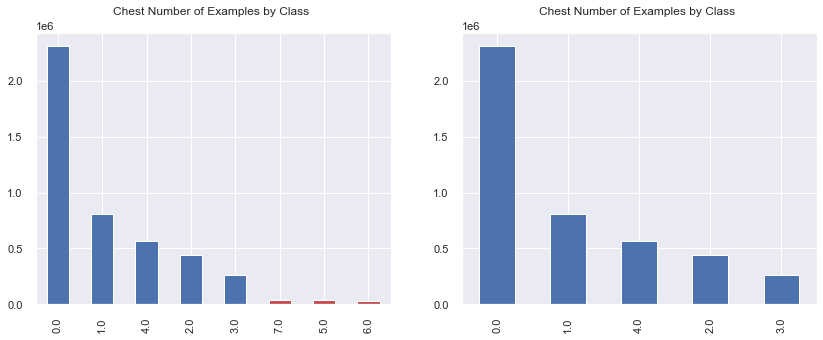

In [18]:
plt.figure(figsize = (14,5))
plt.subplot(1, 2, 1)
ch_df['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n',
                                     color=['b','b','b','b','b','r','r','r'])
plt.subplot(1, 2, 2)
ch_loc['label'].value_counts().plot(kind='bar', 
                                     title='Chest Number of Examples by Class \n')
print((ch_df['label'].value_counts().sum()), ch_loc['label'].value_counts().sum())
print('Number of Rows Removed:', (ch_df['label'].value_counts().sum()) - 
      ch_loc['label'].value_counts().sum());

**XGBoost for Multi-class Classification** <br>
https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [19]:
# Multiclass ROC AUC Score original script sourced from 
'''
Author: Plog, E
Title: AUC ROC Curve Scoring Function for Multi-class Classification
Date: 2018
Code version: n.a.
Availability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
'''

'\nAuthor: Plog, E\nTitle: AUC ROC Curve Scoring Function for Multi-class Classification\nDate: 2018\nCode version: n.a.\nAvailability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659\n'

# Model Runs: XGBoost Classifier

## Model allChest: All chest features

### Train Test

In [20]:
y = ch_loc.label
x = ch_loc.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)
evalSet = [(x_train, y_train), (x_test, y_test)]

(3514560, 8)
(878640,)


### Check Correlations

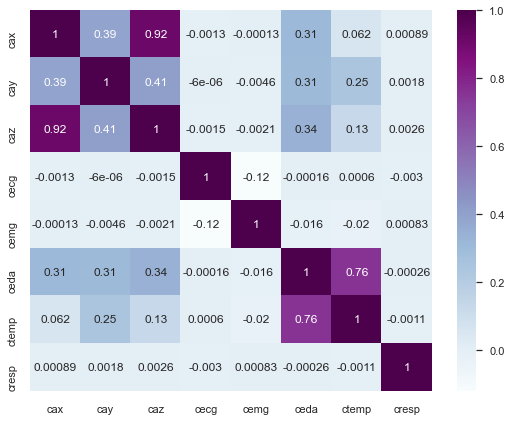

In [21]:
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), annot=True, cmap=plt.cm.BuPu);

    There is a very strong correlation between caz and cax 
    There is strong relationship between eda and temp

### Model Fit and f1 and Balanced Accuracy Scores

In [22]:
%%time
allChest = xgb.XGBClassifier(objective = 'multi:softmax',
                              tree_method = 'gpu_hist',
                              learning_rate = 0.1,
                              n_estimators = 300, 
                              #max_depth = 10,
                              #deterministic_histogram = 'false',
                              gradient_based = 0.1,
                              num_early_stopping_rounds = 20,
                              gamma = 3,
                              #seed = 24,
                              verbosity = 2) 

model_allChest = allChest.fit(x_train,y_train, 
                              eval_metric=['merror'],
                              eval_set = evalSet) 
allChest_pred = allChest.predict(x_test)
allChest_report = (classification_report(y_test,
                                         allChest_pred,
                                         labels=np.unique(allChest_pred),
                                         digits=4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, allChest_pred))
print('----------------------------------------')
print('------------ S4 All Chest Classification Report------------')
print(allChest_report)

[0]	validation_0-merror:0.02246	validation_1-merror:0.02242
[1]	validation_0-merror:0.02191	validation_1-merror:0.02185
[2]	validation_0-merror:0.02185	validation_1-merror:0.02180
[3]	validation_0-merror:0.02188	validation_1-merror:0.02183
[4]	validation_0-merror:0.02183	validation_1-merror:0.02176
[5]	validation_0-merror:0.02151	validation_1-merror:0.02143
[6]	validation_0-merror:0.02144	validation_1-merror:0.02135
[7]	validation_0-merror:0.02143	validation_1-merror:0.02134
[8]	validation_0-merror:0.02125	validation_1-merror:0.02115
[9]	validation_0-merror:0.02117	validation_1-merror:0.02106
[10]	validation_0-merror:0.02101	validation_1-merror:0.02087
[11]	validation_0-merror:0.02095	validation_1-merror:0.02081
[12]	validation_0-merror:0.02076	validation_1-merror:0.02059
[13]	validation_0-merror:0.02067	validation_1-merror:0.02050
[14]	validation_0-merror:0.02049	validation_1-merror:0.02033
[15]	validation_0-merror:0.01814	validation_1-merror:0.01801
[16]	validation_0-merror:0.01808	v

[134]	validation_0-merror:0.00970	validation_1-merror:0.00980
[135]	validation_0-merror:0.00968	validation_1-merror:0.00978
[136]	validation_0-merror:0.00963	validation_1-merror:0.00975
[137]	validation_0-merror:0.00961	validation_1-merror:0.00972
[138]	validation_0-merror:0.00955	validation_1-merror:0.00967
[139]	validation_0-merror:0.00953	validation_1-merror:0.00966
[140]	validation_0-merror:0.00950	validation_1-merror:0.00962
[141]	validation_0-merror:0.00947	validation_1-merror:0.00961
[142]	validation_0-merror:0.00945	validation_1-merror:0.00960
[143]	validation_0-merror:0.00942	validation_1-merror:0.00956
[144]	validation_0-merror:0.00940	validation_1-merror:0.00953
[145]	validation_0-merror:0.00937	validation_1-merror:0.00953
[146]	validation_0-merror:0.00932	validation_1-merror:0.00948
[147]	validation_0-merror:0.00929	validation_1-merror:0.00945
[148]	validation_0-merror:0.00926	validation_1-merror:0.00941
[149]	validation_0-merror:0.00924	validation_1-merror:0.00939
[150]	va

[267]	validation_0-merror:0.00743	validation_1-merror:0.00767
[268]	validation_0-merror:0.00743	validation_1-merror:0.00767
[269]	validation_0-merror:0.00743	validation_1-merror:0.00767
[270]	validation_0-merror:0.00743	validation_1-merror:0.00767
[271]	validation_0-merror:0.00743	validation_1-merror:0.00767
[272]	validation_0-merror:0.00743	validation_1-merror:0.00767
[273]	validation_0-merror:0.00743	validation_1-merror:0.00767
[274]	validation_0-merror:0.00743	validation_1-merror:0.00767
[275]	validation_0-merror:0.00743	validation_1-merror:0.00767
[276]	validation_0-merror:0.00743	validation_1-merror:0.00767
[277]	validation_0-merror:0.00743	validation_1-merror:0.00767
[278]	validation_0-merror:0.00743	validation_1-merror:0.00767
[279]	validation_0-merror:0.00743	validation_1-merror:0.00767
[280]	validation_0-merror:0.00743	validation_1-merror:0.00767
[281]	validation_0-merror:0.00743	validation_1-merror:0.00767
[282]	validation_0-merror:0.00743	validation_1-merror:0.00767
[283]	va

### Confusion Matrix

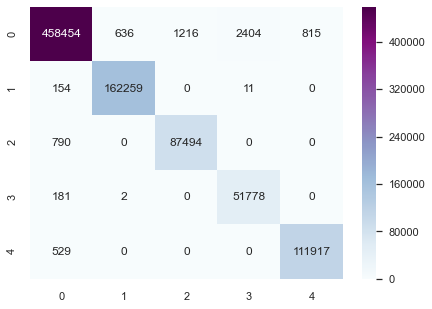

In [23]:
cm = confusion_matrix(y_test, allChest_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );

### Model ACC TEMP EDA

### Test Train Split

In [19]:
less_Emg_Ecg = ch_loc[['ceda', 'ctemp', 'cax', 'cay', 'caz', 'label']]
y = less_Emg_Ecg.label
x = less_Emg_Ecg.drop('label',axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)
print(y_test.shape)

(3514560, 5)
(878640,)


### Model Fit, classification report, and Balanced Accuracy 

In [21]:
%%time
accEdaTemp = XGBClassifier(objective = 'multi:softmax',
                           tree_method = 'gpu_hist',
                           learning_rate = 0.1,
                           gradient_based = 0.1,
                           num_early_stopping_rounds = 20,
                           n_estimators = 300,
                           gamma = 3,
                           verbosity = 2) 

model_accEdaTemp = accEdaTemp.fit(x_train, y_train)
accEdaTemp_pred = accEdaTemp.predict(x_test)
accEdaTemp_report = (classification_report(y_test, 
                                         accEdaTemp_pred, 
                                         labels = np.unique(accEdaTemp_pred),
                                         digits = 4))

print('Balanced Accuracy:', balanced_accuracy_score(y_test, accEdaTemp_pred))
print('---------------------------------------')
print('------------ S4 ACC EDA TEMP Classification Report------------')
print(accEdaTemp_report)

Balanced Accuracy: 0.991238174253089
---------------------------------------
------------ S4 ACC EDA TEMP Classification Report------------
              precision    recall  f1-score   support

         0.0     0.9939    0.9859    0.9899    462873
         1.0     0.9949    0.9983    0.9966    161781
         2.0     0.9808    0.9856    0.9832     88912
         3.0     0.9470    0.9950    0.9704     52420
         4.0     0.9905    0.9913    0.9909    112654

    accuracy                         0.9894    878640
   macro avg     0.9814    0.9912    0.9862    878640
weighted avg     0.9896    0.9894    0.9894    878640

Wall time: 1min 23s


### Confusion matrix

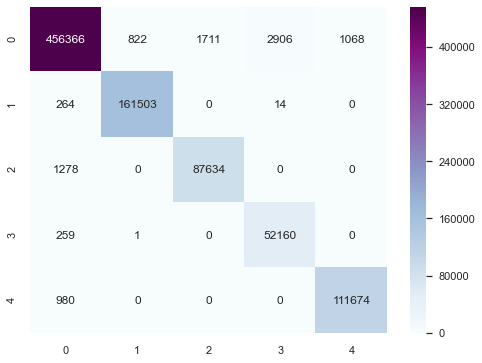

In [23]:
cm = confusion_matrix(y_test, accEdaTemp_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.BuPu );